# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import os

env = UnityEnvironment(file_name=os.path.join(".", "data", "Tennis.exe"))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [9]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.09500000160187483
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.09500000160187483


When finished, you can close the environment.

In [2]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### Visualization Tools ###

Below we are defining some simple tools to help us visualize the data after training the agents.

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(array, n=3):
    cumsum = np.cumsum(array, dtype=float)
    cumsum[n:] = cumsum[n:] - cumsum[:-n]
    return cumsum[n - 1:] / n


def average_last_samples(array, n = 100):
    array = np.array(array)
    avg = []
    for i in range(len(array)):
        min_idx = max(0, i - n)
        avg.append(array[min_idx:i].mean())
    return avg        


def show_scores(scores, threshold_value):
    plt.figure(figsize = (10, 8))
    plt.plot(scores, ".", color = "k", label = "score")
    plt.plot(average_last_samples(scores), "-", color = "r", label = "Last 100 steps")
    plt.plot(moving_average(scores), "-", color = "b", label = "Moving average (3 steps size)")
    plt.axhline(y = threshold_value, color = "g", linestyle = "-.", label = "Avg last 100 steps reward threshold")
    plt.title("Rewards history during training")
    plt.legend()
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.ylim((-1, 3))
    plt.xlim((0, 2000))
    plt.show()

### Training Phase for the agents ###

Now we are going to train the agents using a modified version of the DDPG algorithm. These agents will try to accumulate an average of 0.5 maximum reward (we are taking the maximum reward obtained by the two players in each episode) over the last 100 episodes. 

In [2]:
from collections import deque

import numpy as np
import os
import torch

def ddpg(agents, env, brain_name, output_folder, n_episodes=10000, reward_threshold = 0.5):
    """Deep Deterministic Policy Gradient.    
    Params
    ======
        agents (list of Agent class type): A list of instances of the Agent Class that will be trained
        env (UnityEnvironment): environment in which we are popping states to be processed by the agents
        brain_name (string): The name of the current brain being used by the environment
        n_episodes (int): maximum number of training episodes   
        reward_threshold (float): The averaged reward over all agents in the last 100 episodes
    """    
    scores_episode = []
    scores_window = deque(maxlen = 100)
    for i_episode in range(1, n_episodes + 1):
        for agent in agents:
            agent.reset()
        scores = np.zeros(len(agents))
        env_info = env.reset(train_mode = True)[brain_name]
        states = env_info.vector_observations
        while True:
            actions = [agent.act(states[idx]) for idx, agent in enumerate(agents)]
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            scores += rewards                        
            for idx, agent in enumerate(agents):
                agent.step(states[idx], actions[idx], rewards[idx], next_states[idx], dones[idx])
            if np.any(dones):
                break
            states = next_states        
        score = np.max(scores)
        scores_window.append(score)
        scores_episode.append(score)
        end_liner = "\r" if i_episode % 100 != 0 else "\n"
        print('\rEpisode {}\tEpisode Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)), end = end_liner)
        if np.mean(scores_window) >= reward_threshold:
            print()
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))            
            os.makedirs(output_folder, exist_ok = True)
            for idx, agent in enumerate(agents):
                torch.save(agent.actor_local.state_dict(), os.path.join(output_folder, "actor_{}_checkpoint.pth".format(idx)))
                torch.save(agent.critic_local.state_dict(), os.path.join(output_folder, "critic_{}_checkpoint.pth".format(idx)))
            break
    return scores_episode

Now we instantiate the environment and the agents.

In [3]:
from unityagents import UnityEnvironment
from agents import DDPG_Agent, ReplayBuffer
from models import Actor

import torch

parameters_dict = {
    "buffer_size": int(1e5),
    "batch_size": 128,
    "gamma": 0.99,
    "tau": 1e-3,
    "lr_actor": 2e-4,
    "lr_critic": 2e-4,
    "weight_decay": 0,
    "n_updates": 1,
    "update_every_nsteps": 1,
    "nhidden_actor": [128, 128],
    "nhidden_critic": [128, 128],
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

env = UnityEnvironment(file_name=os.path.join(".", "data", "Tennis.exe"), no_graphics = True)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
states = env_info.vector_observations
action_size = brain.vector_action_space_size
state_size = states.shape[1]
seed = 0

parameters_dict.update(
    {
        "memory": ReplayBuffer(action_size, parameters_dict["buffer_size"], parameters_dict["batch_size"], seed, parameters_dict["device"]),
#         "actor_target": Actor(state_size, action_size, seed, parameters_dict["nhidden_actor"]).to(parameters_dict["device"]),
    }
)

agents = [DDPG_Agent(state_size, action_size, random_seed = seed, **parameters_dict) for i in range(num_agents)]
print(agents[0].actor_target)
print(agents[0].critic_target)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Actor(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)
Critic(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=130, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)


Episode 100	Episode Score: 0.00	Average Score: 0.01
Episode 200	Episode Score: 0.00	Average Score: 0.00
Episode 300	Episode Score: 0.00	Average Score: 0.00
Episode 400	Episode Score: 0.00	Average Score: 0.00
Episode 500	Episode Score: 0.00	Average Score: 0.00
Episode 600	Episode Score: 0.00	Average Score: 0.01
Episode 700	Episode Score: 0.00	Average Score: 0.04
Episode 800	Episode Score: 0.10	Average Score: 0.07
Episode 900	Episode Score: 0.09	Average Score: 0.10
Episode 1000	Episode Score: 0.10	Average Score: 0.09
Episode 1100	Episode Score: 0.09	Average Score: 0.10
Episode 1200	Episode Score: 0.09	Average Score: 0.10
Episode 1300	Episode Score: 0.10	Average Score: 0.11
Episode 1400	Episode Score: 0.09	Average Score: 0.11
Episode 1491	Episode Score: 2.60	Average Score: 0.51

Environment solved in 1391 episodes!	Average Score: 0.51


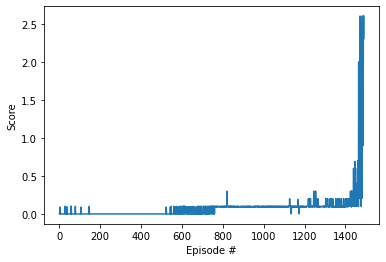

In [4]:
reward_threshold = 0.5
output_folder = os.path.join(".", "trained_models")
scores = ddpg(agents, env, brain_name, output_folder, reward_threshold = reward_threshold)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

C:\Users\ilberto\anaconda3\envs\dlrnd\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
C:\Users\ilberto\anaconda3\envs\dlrnd\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


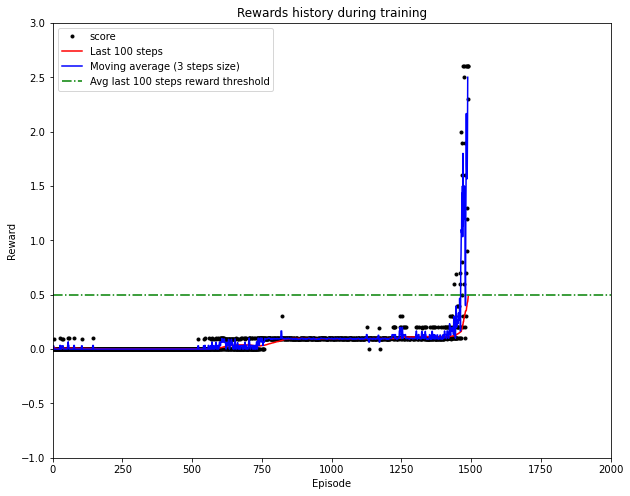

In [7]:
show_scores(scores, reward_threshold)